In [1]:
words = open('names.txt').read().splitlines()

In [2]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [5]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size

        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)

            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X, Y = build_dataset(words)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev= build_dataset(words[n1:n2])
Xtr, Ytr = build_dataset(words[n2:])

In [6]:
n1

25626

In [7]:
C = torch.randn((27, 2))

In [8]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [9]:
W1 = torch.randn((6, 100))
B1 = torch.randn(100)

In [10]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + B1)

In [11]:
W2 = torch.randn((100, 27))
B2 = torch.randn(27)


In [12]:
logits = h @ W2 + B2
logits

tensor([[ 10.7382,  -3.4676,   8.7141,  ..., -11.0260,  12.0768,   7.5095],
        [ 12.4832,  -6.1449,  11.8447,  ...,   4.5066,   0.8360,   4.2492],
        [ 10.7392,   3.6123,   0.2610,  ...,  -0.9214,   6.2948,  25.5589],
        ...,
        [ -3.5306,  -1.4686,   1.8489,  ...,   6.2389, -14.0481,  11.6806],
        [ -7.1807,   3.5569,  -1.0688,  ...,  -1.7709,  -9.6077,   0.9283],
        [ -2.2059,  -6.5316,  -3.9796,  ...,  -2.1211,  -6.8526,   4.5415]])

In [13]:
counts = logits.exp()

In [14]:
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([228146, 27])

In [15]:
# loss = -prob[torch.arange(32), Y].log().mean()
# loss

In [16]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters: p.requires_grad = True

In [17]:
sum(p.nelement() for p in parameters)

11897

In [18]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [19]:
torch.device("cuda")

device(type='cuda')

In [20]:
torch.device('cpu')

device(type='cpu')

In [21]:
lri = []
lossi = []
stepi = []

In [22]:
# forward pass
for i in range(200000):
    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (32,))

    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    for p in parameters:
        p.grad = None

    loss.backward()

    # lr = lrs[i]
    lr = 0.1 if i <= 100000 else 0.01
    # lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    stepi.append(i)
    lossi.append(loss.log10().item())

loss.item()

1.7507058382034302

In [23]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

1.8011548519134521

In [24]:
emb = C[Xdev]
print(emb.view(-1, 30).shape)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

torch.Size([22655, 30])


2.535964250564575

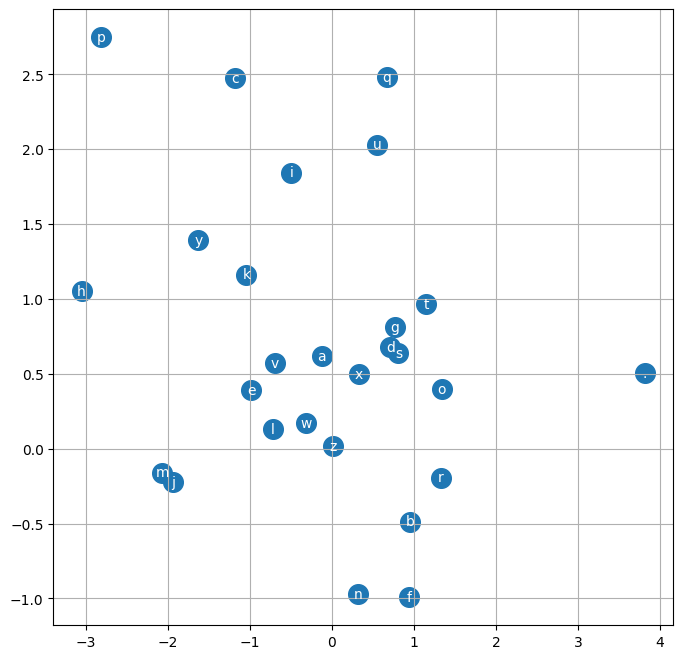

In [25]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('white')

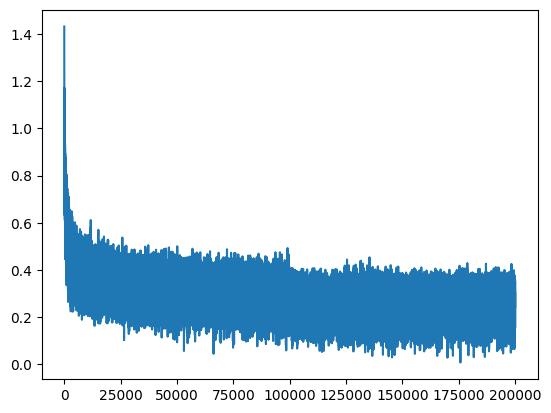

In [26]:
plt.plot(stepi, lossi)

In [27]:
loss.item()

2.535964250564575

In [28]:
for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        # print(emb.view(-1, 30))
        # print(W1.shape)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1);
        ix = torch.multinomial(probs, num_samples=1).item()
        
        if ix == 0:
            break

        context = context[1:] + [ix]
        out.append(ix)

    print(''.join(itos[i] for i in out))

bryely
laptin
lid
yuleigh
ilo
makiran
cashepal
jess
maritt
kuisyna
oluw
loa
leason
jesslyn
xudy
laiaanaverlyn
mani
zeel
dina
mats
